### Code Hist.

 - CODE : KIER Data_전처리 (결측 제거)  
 - DESC  
   &ensp; : int_Domain 코드의 변경에 따라,   
   &emsp; 보간된 데이터에 대한 IQR 방식의 이상치 제거 실행    
 - DATE  
    &ensp; 2024-02-07 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) M02-01_Data_04_Interpolation_Mean-Inst.ipynb로부터 분리  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Error Fix  

## 01. Code

### 01-01. Init

#### 01-01-01. Init_Module Import

#### Module import

In [1]:
#region Import_Basic Module
## Basic
import os, sys, warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.path.dirname(os.path.abspath('./__file__'))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('./__file__'))))
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = '{:.10f}'.format

import math, random

## Datetime
import time, datetime as dt
from datetime import datetime, date, timedelta

## glob
import glob, requests, json
from glob import glob

## 시각화
import matplotlib.pyplot as plt, seaborn as sns
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## Split, 정규화
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans

# Clustering 알고리즘의 성능 평가 측도
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## For Web
import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import tqdm
from tqdm.notebook import tqdm
#endregion Import_Basic Module

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch, torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf, tensorflow_addons as tfa
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.models import Sequential, load_model
    from keras_flops import get_flops
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## Import_Local
from Src_Dev_Common import Data_Datetime as com_date, Data_Preprocessing as com_Prep, KMA_Weather as com_KMA, KECO_AirKor as com_KECO, KASI_Holiday as com_Holi, KIER_Usage_M02 as com_KIER_M02

### 01-01-02. Config (Directory, Params)

In [4]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"], os.environ['TF_DETERMINISTIC_OPS'] = str(SEED), "1"

In [5]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y, str_now_m, str_now_d = pd.datetime.now().year, pd.datetime.now().month, pd.datetime.now().day
str_now_hr, str_now_min = pd.datetime.now().hour, pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-08-14 09:52:38.317415
2024 / 8 / 14
9 : 52


In [6]:
## Dict_Domain
int_domain = 0

## Domain, ACCU/INST Column
str_domain, str_col_accu, str_col_inst = com_KIER_M02.create_domain_str(int_domain)
## Directory Root
str_dirData, str_dir_raw, str_dir_cleansed, str_dirName_bld, str_dirName_h = com_KIER_M02.create_dir_str(str_domain)

## File
str_fileRaw, str_fileRaw_hList = str('KIER_RAW_' + str_domain + '_H_ID_Adopted.csv'), str('KIER_hList_Common.csv')

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

0 : ELEC
['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'DATE_1M_2023-10-20.csv', 'KIER 전처리 현황_2024-06-25.xlsx', 'KIER_0_Raw', 'KIER_1_Cleansed', 'KIER_2_BLD', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_DATA_OLD', 'KIER_ETC', 'KIER_hList_Comparison_2024-06-26.xlsx', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', '[IITP] 데이터 테이블 정리 (공유 원본).docx']

['KIER_ELEC_561-1-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-4_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-4_ACCU_01_Raw.csv', 'KIER_ELEC_561-11-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-11-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-11-3_ACCU_01_Raw.csv'

In [7]:
## "KIER_01-01_Data_hList.ipynb"로부터 만들어진 Bld/F/H List
df_kier_hList = pd.read_csv(str_dir_raw + str_fileRaw_hList, index_col = 0)
# print(df_kier_hList.shape, ' /// ', df_kier_hList.columns)
# df_kier_hList

## 01-02. Data Load (df_raw)

### 01-02-01. KIER (Energy Usage : INST Interpolated)

In [8]:
## Load Intergrated INST Usage
str_file_inst = 'KIER_' + str_domain + '_INST_10MIN_2st_Linear.csv'
str_dirName_h
df_INST_Intergrated = pd.read_csv(str_dirName_h + str_file_inst, index_col = 0)
df_INST_Intergrated = com_date.create_col_datetime(df_INST_Intergrated, 'METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE').drop(labels=['None'], axis = 1)

## 각 호실별 사용량
list_col_tar = list(df_INST_Intergrated.columns)[6:-2]

df_INST_Intergrated

,METER_DATE,YEAR,MONTH,DAY,HOUR,MINUTE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,...,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022-07-17 23:20:00,2022,7,17,23,20,0.1700000000,0.1700000000,0.0400000000,0.2900000000,...,0.0300000000,0.0400000000,0.0500000000,0.0800000000,0.0600000000,0.0600000000,0.0300000000,0.1000000000,0.0810000000,27.5400000000
1,2022-07-17 23:30:00,2022,7,17,23,30,0.1600000000,0.1800000000,0.0300000000,0.2100000000,...,0.0200000000,0.0400000000,0.0600000000,0.0600000000,0.0500000000,0.0772916667,0.0200000000,0.0900000000,0.0772916667,25.9700000000
2,2022-07-17 23:40:00,2022,7,17,23,40,0.1400000000,0.2300000000,0.0300000000,0.2400000000,...,0.0400000000,0.0300000000,0.0500000000,0.0600000000,0.0500000000,0.0759064327,0.0300000000,0.0900000000,0.0759064327,25.9600000000
3,2022-07-17 23:50:00,2022,7,17,23,50,0.1400000000,0.2100000000,0.0200000000,0.2700000000,...,0.0400000000,0.0400000000,0.0400000000,0.0600000000,0.0400000000,0.0500000000,0.0300000000,0.0800000000,0.0738053097,25.0200000000
4,2022-07-18 00:00:00,2022,7,18,0,0,0.1500000000,0.2100000000,0.0300000000,0.2200000000,...,0.0400000000,0.0400000000,0.0300000000,0.0600000000,0.0600000000,0.0300000000,0.0200000000,0.0600000000,0.0706528190,23.8100000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99165,2024-06-05 14:50:00,2024,6,5,14,50,0.0400000000,0.0600000000,0.2300000000,0.0300000000,...,0.0400000000,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,9.2500000000
99166,2024-06-05 15:00:00,2024,6,5,15,0,0.0300000000,0.0600000000,0.3400000000,0.0300000000,...,0.0800000000,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,8.3600000000
99167,2024-06-05 15:10:00,2024,6,5,15,10,0.0500000000,0.0700000000,0.2900000000,0.0200000000,...,0.0500000000,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,7.9900000000
99168,2024-06-05 15:20:00,2024,6,5,15,20,0.0500000000,0.1000000000,0.1300000000,0.0200000000,...,0.0900000000,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,5.9800000000


Text(0.5, 1.0, 'Instantaneous Electric Usage in certain household')

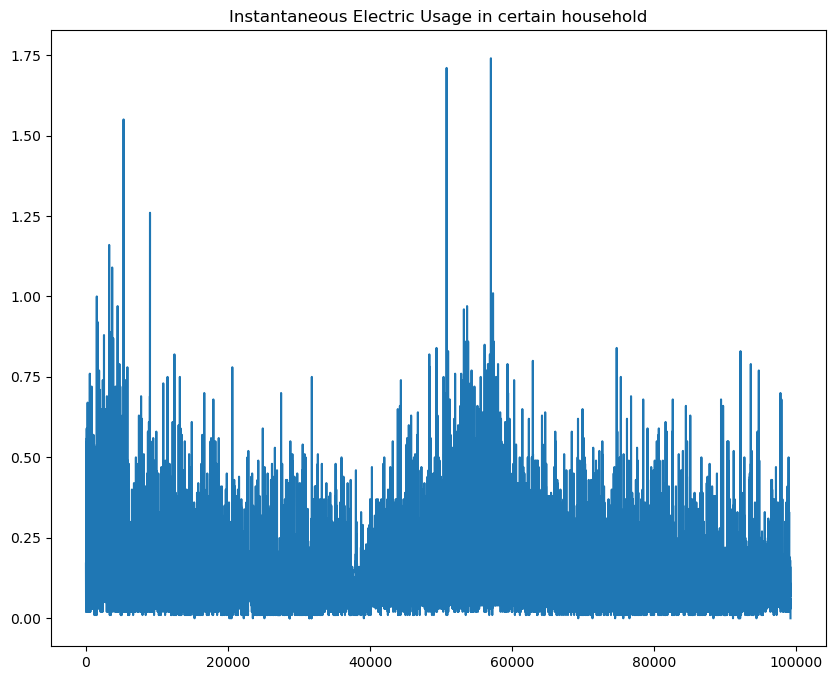

In [9]:
## Target Column 확인
list_col_tar

## 데이터 확인
plt.plot(df_INST_Intergrated[str_col_inst + '_561-1-1'])
plt.title('Instantaneous Electric Usage in certain household')

## IQR Code

In [10]:
## 여기서 IQR방식으로 전처리
for tar_col in list_col_tar:
    print(tar_col)
    df_INST_Intergrated = com_Prep.del_outlier_Usages(df_INST_Intergrated, tar_col, 1)
print(df_INST_Intergrated.shape, ' /// ', df_INST_Intergrated.columns)
df_INST_Intergrated

ELEC_INST_EFF_561-1-1
===============  IQR Range =============== 
0.37499999999909056
0.180000000000291
0.1299999999991997
0.0842364762302559
0.0500000000010913
-0.14499999999770824
===============  IQR Range =============== 
cnt_outlier = 1544
1544
ELEC_INST_EFF_561-1-2
===============  IQR Range =============== 
0.3500000000005911
0.1700000000000727
0.12000000000034561
0.0699999999997089
0.0499999999997271
-0.13000000000079132
===============  IQR Range =============== 
cnt_outlier = 1344
1344
ELEC_INST_EFF_561-1-3
===============  IQR Range =============== 
0.35499999999967696
0.1599999999998544
0.1299999999998817
0.0499999999999545
0.0299999999999727
-0.16499999999984988
===============  IQR Range =============== 
cnt_outlier = 2094
2094
ELEC_INST_EFF_561-1-4
===============  IQR Range =============== 
0.46500000000241903
0.2100000000009458
0.1700000000009822
0.0699999999997089
0.0399999999999636
-0.21500000000150968
===============  IQR Range =============== 
cnt_outlier = 966
966

KeyboardInterrupt: 

Text(0.5, 1.0, 'Instantaneous Electric Usage in certain household')

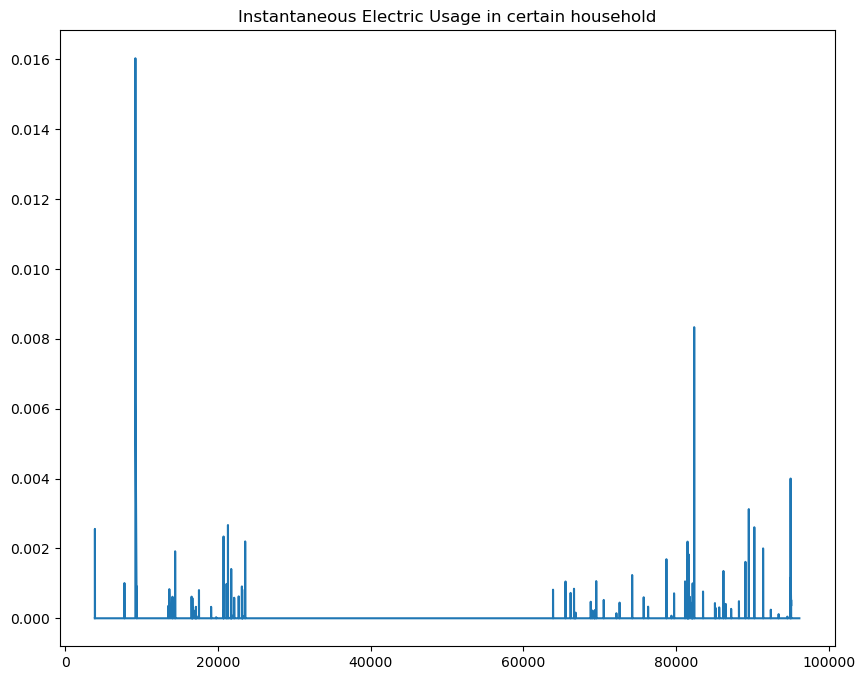

In [ ]:
## 데이터 확인
plt.plot(df_INST_Intergrated[str_col_inst + '_561-1-1'])
plt.title('Instantaneous Electric Usage in certain household')
# plt.xlim(0, 5000)

In [ ]:
## Export Dataframe
str_file = 'KIER_' + str_domain + '_INST_03_IQR.csv'
df_INST_Intergrated.to_csv(str_dirName_h + str_file)

## 처리 단계별 데이터 비교

In [11]:
str_file = 'KIER_' + str_domain + '_INST_01_10min.csv'
df_tmp_01 = pd.read_csv(str_dirName_h + str_file, index_col = 0)
str_file = 'KIER_' + str_domain + '_INST_10MIN_2st_Linear.csv'
df_tmp_02 = pd.read_csv(str_dirName_h + str_file, index_col = 0)
str_file = 'KIER_' + str_domain + '_INST_03_IQR.csv'
df_tmp_03 = pd.read_csv(str_dirName_h + str_file, index_col = 0)

period_tmp = df_tmp_03['METER_DATE']

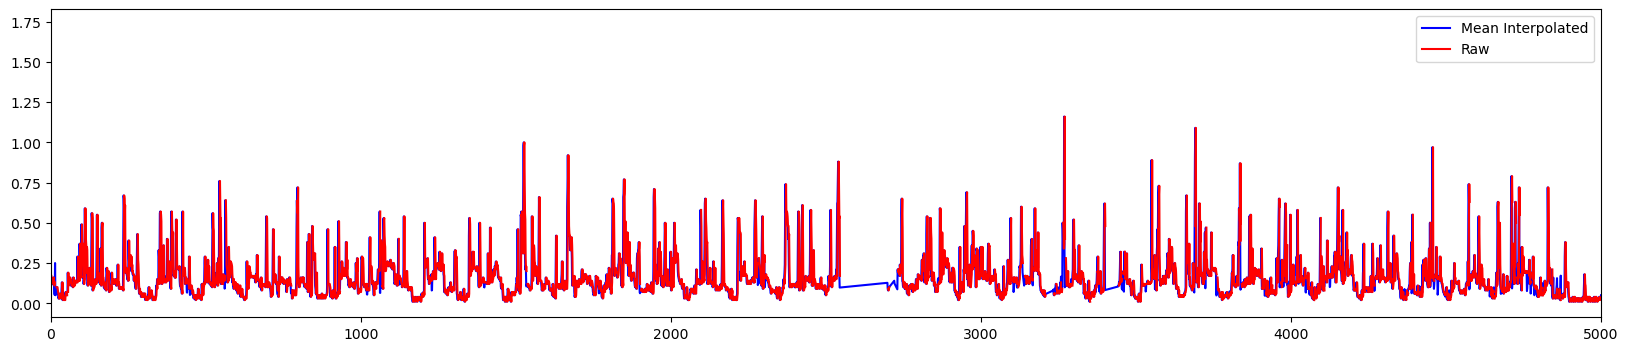

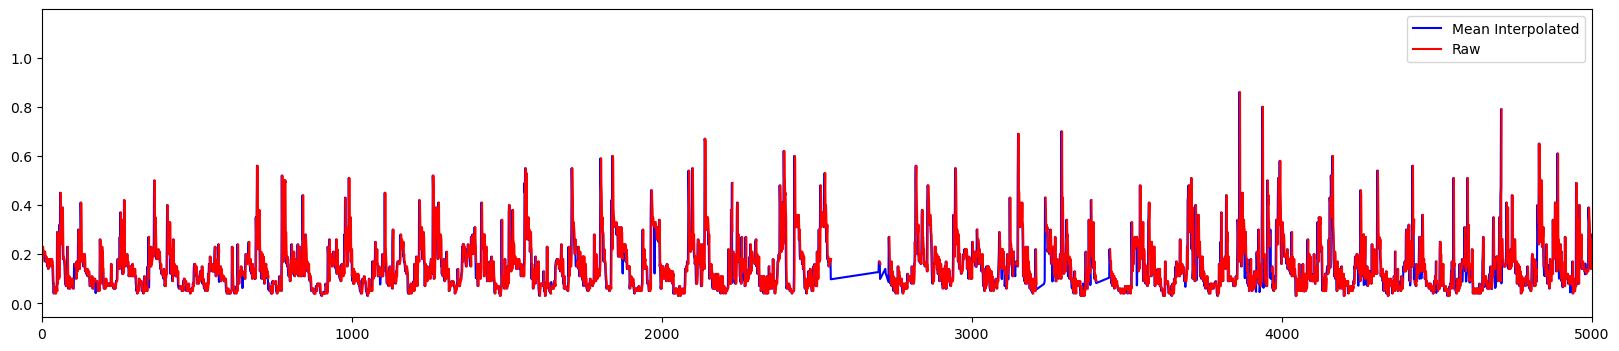

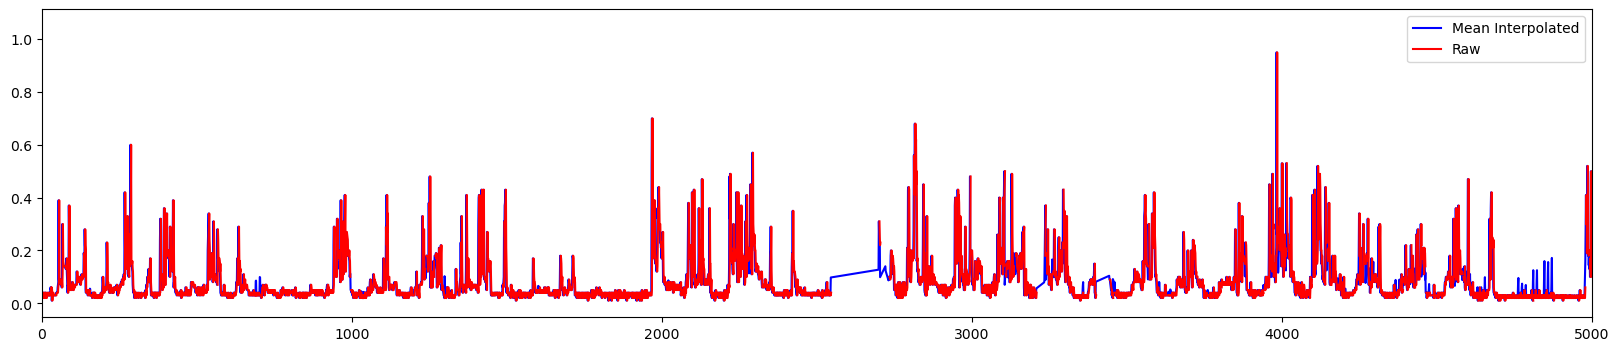

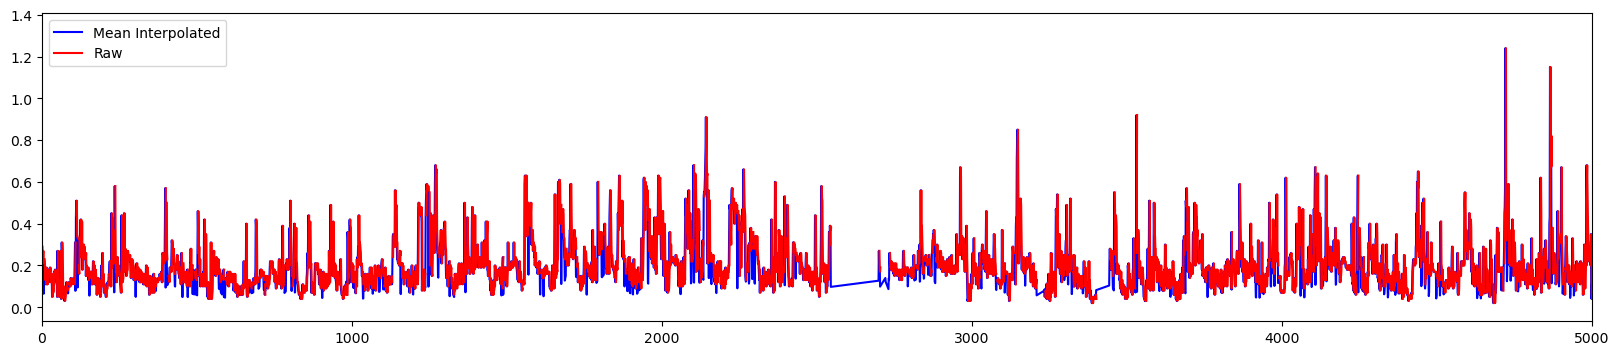

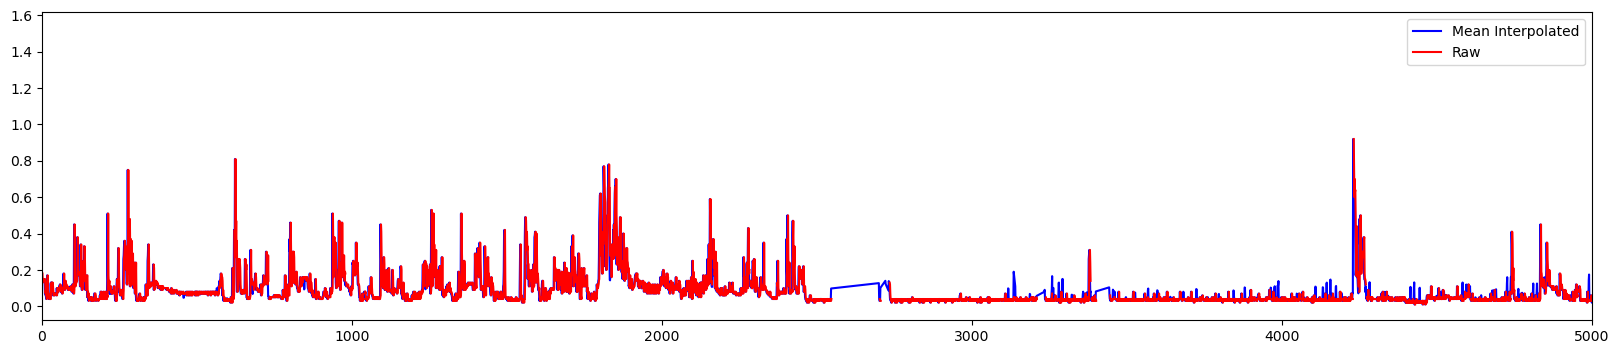

In [12]:
## list_col_tar = list(df_INST_Intergrated.columns)[6:-2] ## 각 세대별 사용량

for tar_col in list_col_tar[0:5]:
    plt.figure(figsize=(20,4))

    ## Phase 2 vs Phase 1 (Interpolated vs Raw)
    plt.plot(df_tmp_02[tar_col], color='blue', label='Mean Interpolated')
    plt.plot(df_tmp_01[tar_col], color='red', label='Raw')
    # plt.plot(df_tmp_03[tar_col], color='green', label='IQR')

    ## 상세보기를 위한 범위 축소
    plt.xlim(0, 5000)
    plt.legend()
    plt.show()

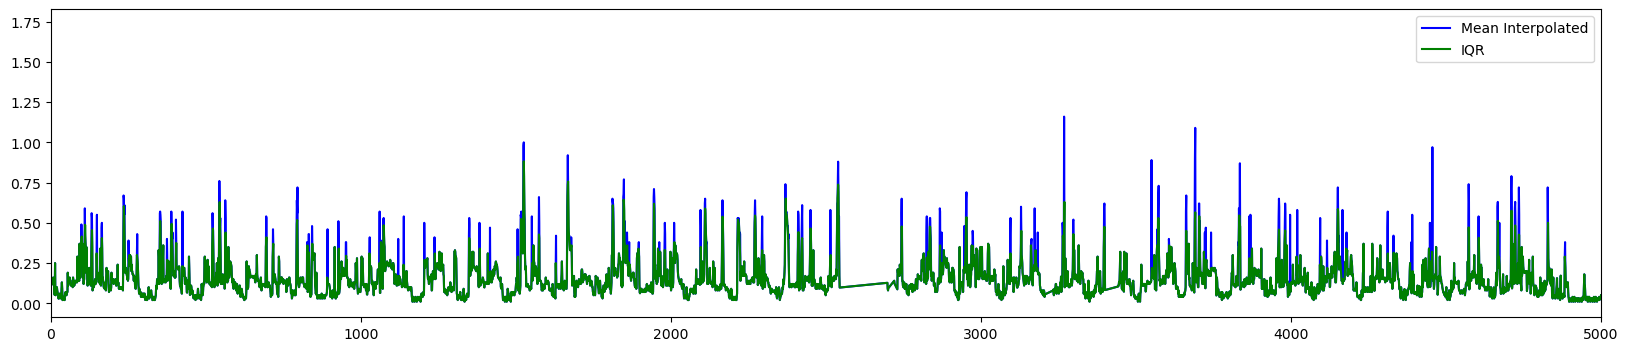

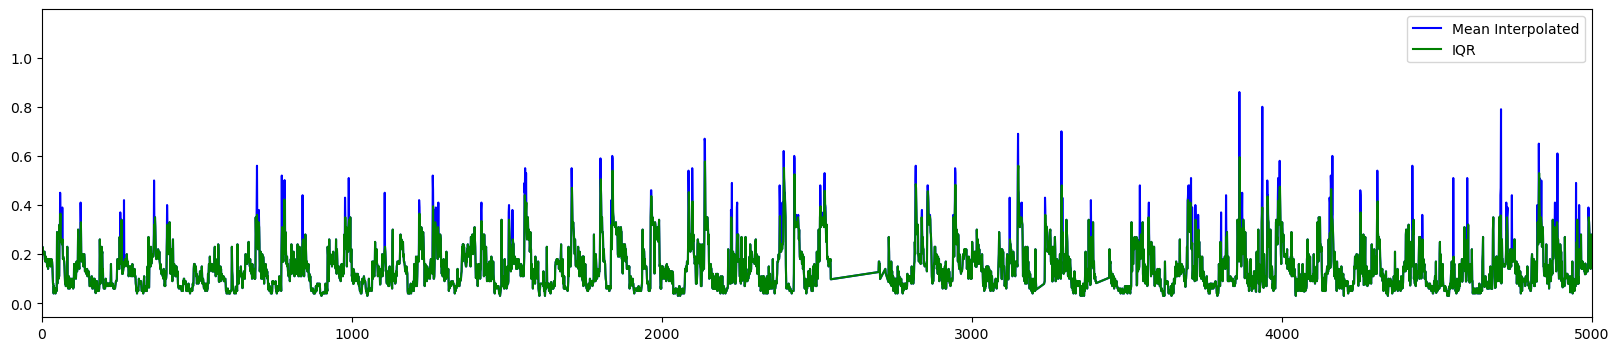

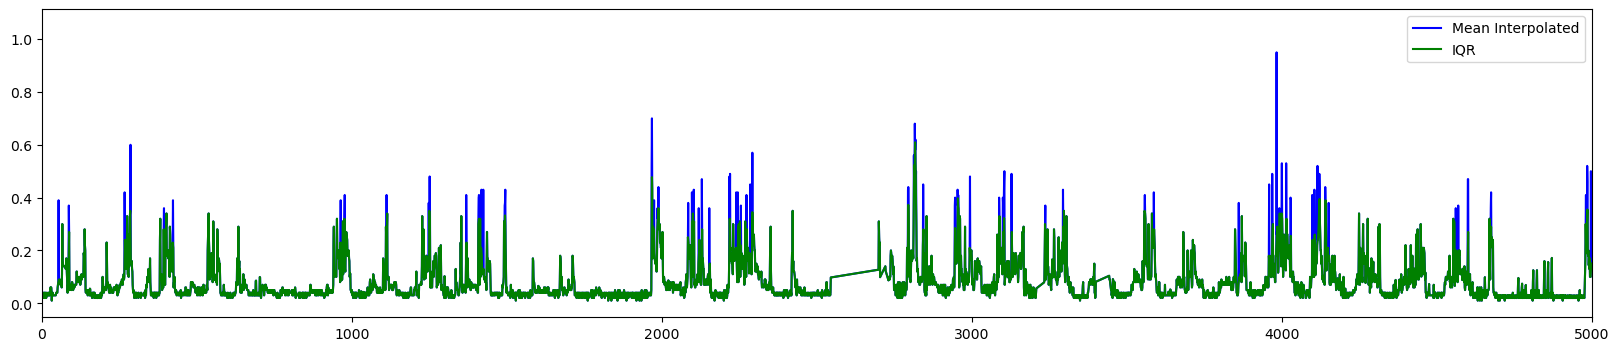

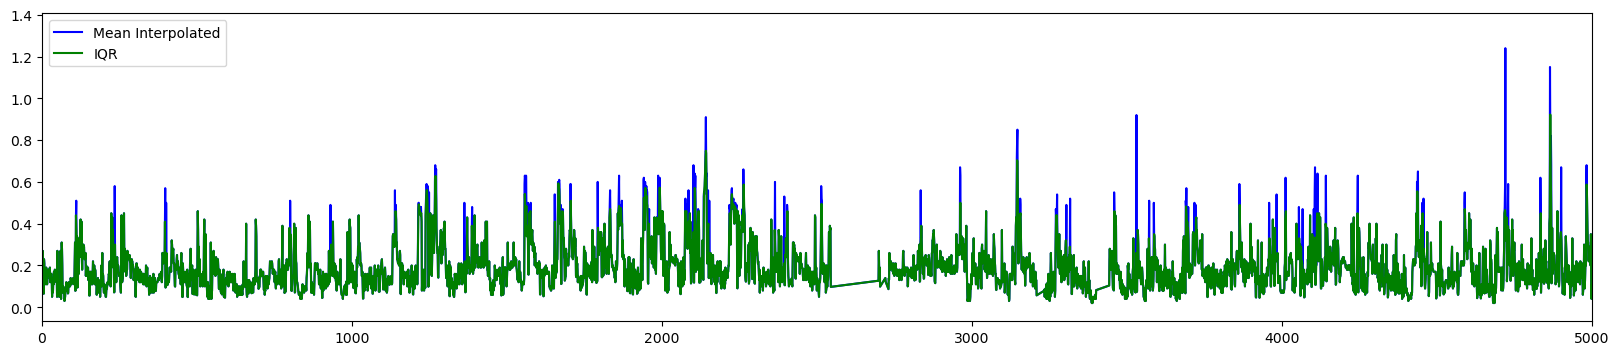

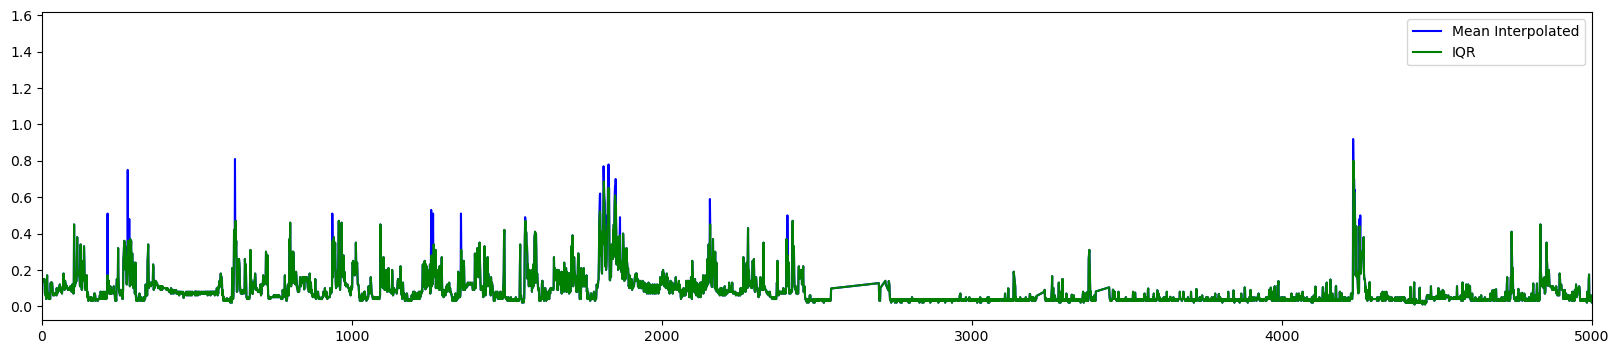

In [13]:
for tar_col in list_col_tar[0:5]:
    plt.figure(figsize=(20,4))

    ## Phase 2 vs Phase 3 (Interpolated vs IQR)
    # plt.plot(df_tmp_01[tar_col], color='red', label='Raw')
    plt.plot(df_tmp_02[tar_col], color='blue', label='Mean Interpolated')
    plt.plot(df_tmp_03[tar_col], color='green', label='IQR')
    
    ## 상세보기를 위한 범위 축소
    plt.xlim(0, 5000)
    plt.legend()
    plt.show()

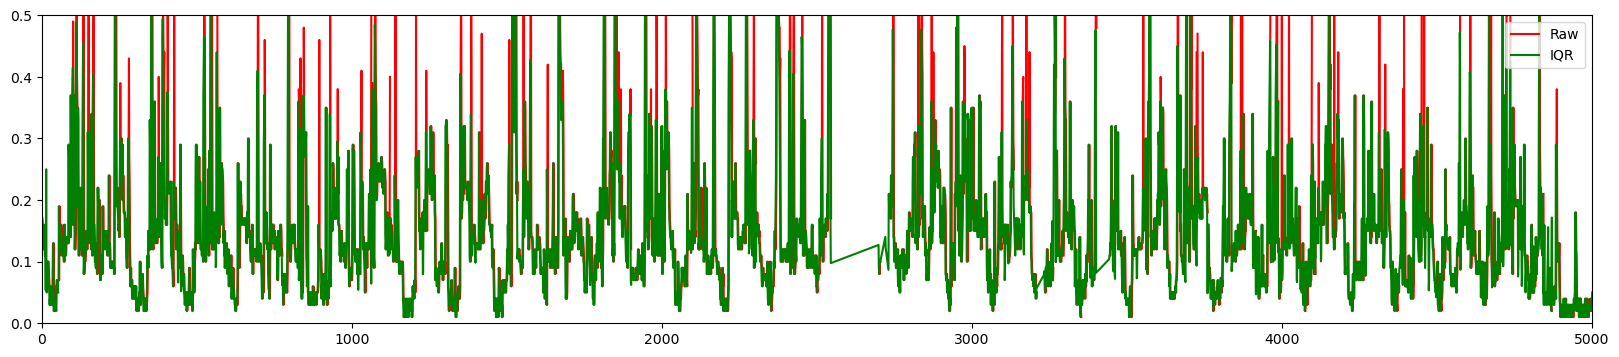

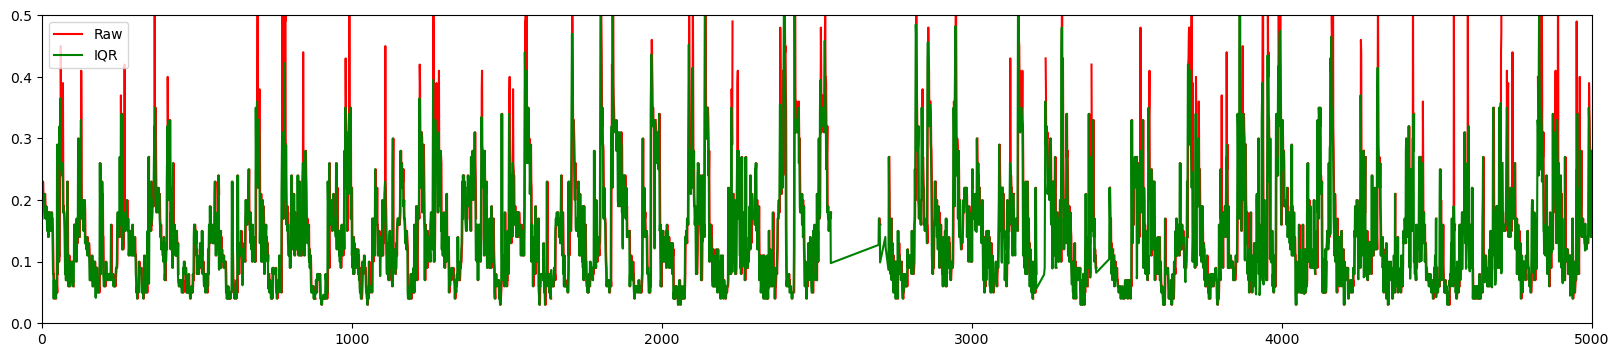

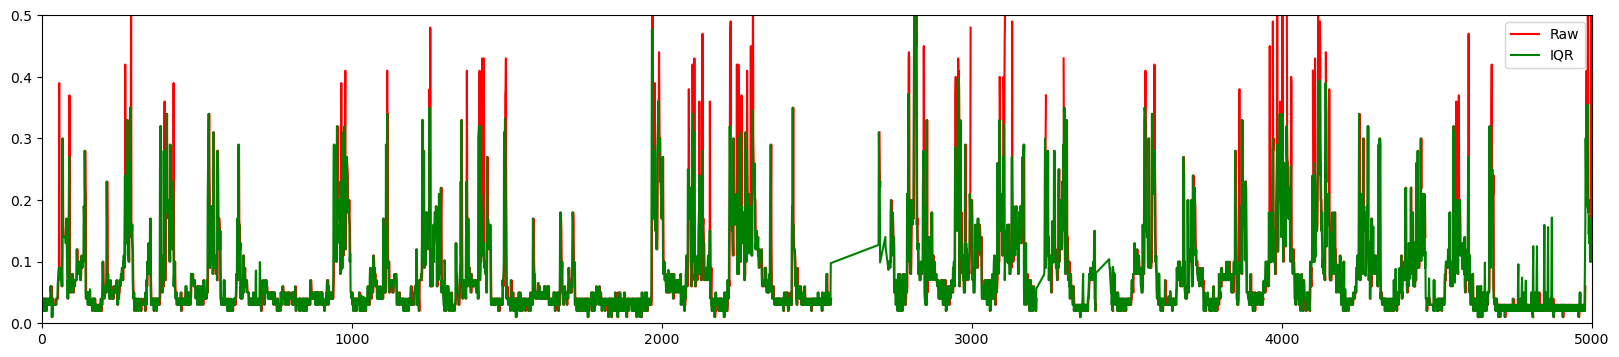

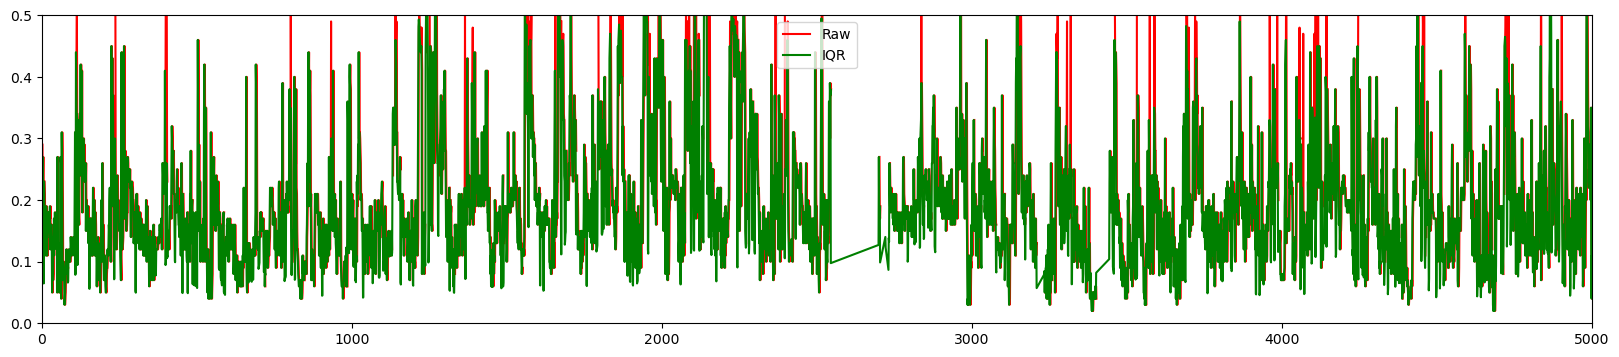

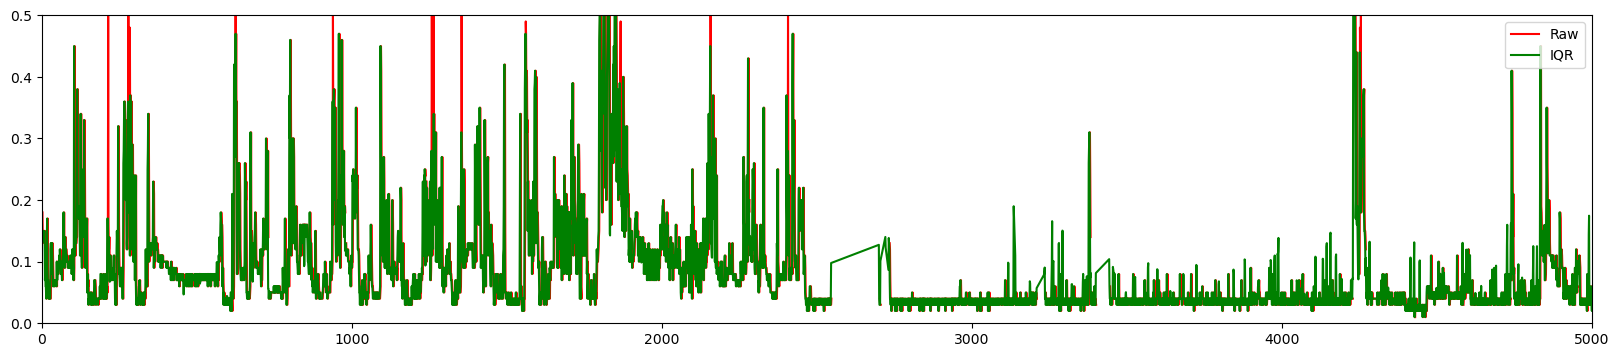

In [17]:
for tar_col in list_col_tar[0:5]:
    plt.figure(figsize=(20,4))

    ## Phase 1 vs Phase 3 (Raw vs IQR)
    # plt.plot(df_tmp_02[tar_col], color='blue', label='Mean Interpolated')
    plt.plot(df_tmp_01[tar_col], color='red', label='Raw')
    plt.plot(df_tmp_03[tar_col], color='green', label='IQR')

    ## 상세보기를 위한 범위 축소
    plt.xlim(0, 5000)
    plt.ylim(0, 0.5)
    plt.legend()
    plt.show()

## Column 갱신 : SUM_OF_INST / MEAN_OF_INST

In [15]:
df_kier_Calc = df_INST_Intergrated[list_col_tar]
df_INST_Intergrated['MEAN_OF_INST'], df_INST_Intergrated['SUM_OF_INST'] = df_kier_Calc.mean(axis = 1), df_kier_Calc.sum(axis = 1)
df_INST_Intergrated

,METER_DATE,YEAR,MONTH,DAY,HOUR,MINUTE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,...,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2,MEAN_OF_INST,SUM_OF_INST
0,2022-07-17 23:20:00,2022,7,17,23,20,0.1700000000,0.1700000000,0.0400000000,0.2900000000,...,0.0300000000,0.0400000000,0.0500000000,0.0800000000,0.0600000000,0.0600000000,0.0300000000,0.1000000000,0.0800086207,27.8430000000
1,2022-07-17 23:30:00,2022,7,17,23,30,0.1600000000,0.1800000000,0.0300000000,0.2100000000,...,0.0200000000,0.0400000000,0.0600000000,0.0600000000,0.0500000000,0.0772916667,0.0200000000,0.0900000000,0.0772916667,26.8975000000
2,2022-07-17 23:40:00,2022,7,17,23,40,0.1400000000,0.2300000000,0.0300000000,0.2400000000,...,0.0400000000,0.0300000000,0.0500000000,0.0600000000,0.0500000000,0.0759064327,0.0300000000,0.0900000000,0.0759064327,26.4154385965
3,2022-07-17 23:50:00,2022,7,17,23,50,0.1400000000,0.2100000000,0.0200000000,0.2700000000,...,0.0400000000,0.0400000000,0.0400000000,0.0600000000,0.0400000000,0.0500000000,0.0300000000,0.0800000000,0.0738053097,25.6842477876
4,2022-07-18 00:00:00,2022,7,18,0,0,0.1500000000,0.2100000000,0.0300000000,0.2200000000,...,0.0400000000,0.0400000000,0.0300000000,0.0600000000,0.0600000000,0.0300000000,0.0200000000,0.0600000000,0.0706528190,24.5871810089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99165,2024-06-05 14:50:00,2024,6,5,14,50,0.0400000000,0.0600000000,0.2300000000,0.0300000000,...,0.0400000000,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,0.0511049724,17.7845303867
99166,2024-06-05 15:00:00,2024,6,5,15,0,0.0300000000,0.0600000000,0.3400000000,0.0300000000,...,0.0800000000,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,0.0477714286,16.6244571429
99167,2024-06-05 15:10:00,2024,6,5,15,10,0.0500000000,0.0700000000,0.2900000000,0.0200000000,...,0.0500000000,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,0.0453977273,15.7984090909
99168,2024-06-05 15:20:00,2024,6,5,15,20,0.0500000000,0.1000000000,0.1300000000,0.0200000000,...,0.0900000000,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0515517241,0.0508045977,17.6800000000


In [16]:
## Export Dataframe
str_file = 'KIER_' + str_domain + '_INST_03_IQR.csv'
df_INST_Intergrated.to_csv(str_dirName_h + str_file)